In [1]:
%matplotlib inline

from __future__ import print_function, division

# Author: Xiang Wang

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader


import torchvision
from torchvision import datasets, models, transforms, models

from tensorboardX import SummaryWriter

import numpy as np
import time
import os
import copy
import pickle

import matplotlib.pyplot as plt

plt.ion()   # interactive mode

In [2]:
import cv2
from pathlib import Path
from torch.nn import functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 一、数据增强与加载

void copyMakeBorder(InputArray src, OutputArray dst, int top, int bottom, int left, int right, int borderType, const Scalar& value=Scalar() )

参数：

InputArray src：输入图像

OutputArray dst：输出的图像

int top, int bottom, int left, int right：表示对边界每个方向添加的像素个数，就是边框的粗细程度

int borderType：表示边界的类型

int borderType：表示边界的类型

有下面几种类型：


borderType：扩充边缘的类型，就是外插的类型，OpenCV中给出以下几种方式

 * BORDER_REPLICATE            重复：  就是对边界像素进行复制
 * BORDER_REFLECT               反射：对感兴趣的图像中的像素在两边进行复制例如：fedcba|abcdefgh|hgfedcb    反射
 * BORDER_REFLECT_101       反射101： 例子：gfedcb|abcdefgh|gfedcba
 * BORDER_WRAP                   外包装：cdefgh|abcdefgh|abcdefg
 * BORDER_CONSTANT           常量复制：例子：iiiiii|abcdefgh|iiiiiii

In [5]:
def load_image(path, mask = False):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (newtwork requirement)
    
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, _ = img.shape

    # Padding in needed for UNet models because they need image size to be divisible by 32 
    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
        
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
        
    # 扩充边缘 (128, 128, 3)
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)
    if mask:
        # 将0~255转化成0~1
        img = img[:, :, 0:1] // 255
        return torch.from_numpy(np.transpose(img, (2, 0, 1)).astype('float32'))
    else:
        img = img / 255.0
        return torch.from_numpy(np.transpose(img, (2, 0, 1)).astype('float32'))

In [6]:
# Adapted from vizualization kernel
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils import data

class TGSSaltDataset(data.Dataset):
    def __init__(self, root_path, file_list, is_test = False):
        self.is_test = is_test
        self.root_path = root_path
        self.file_list = file_list
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        
        file_id = self.file_list[index]
        
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        
        image = load_image(image_path)
        
        if self.is_test:
            return (image,)
        else:
            mask = load_image(mask_path, mask = True)
            return image, mask




In [7]:
directory = 'C:/1.PlayGround/Salt/data/'

In [8]:
depths_df = pd.read_csv(os.path.join(directory, 'train.csv'))

train_path = os.path.join(directory, 'train')
file_list = list(depths_df['id'].values)

In [9]:
# https://github.com/leigh-plt/cs231n_hw2018/blob/master/assignment2/pytorch_tutorial.ipynb
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [10]:
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook

file_list_val = file_list[::10]
file_list_train = [f for f in file_list if f not in file_list_val]
dataset = TGSSaltDataset(train_path, file_list_train)
dataset_val = TGSSaltDataset(train_path, file_list_val)

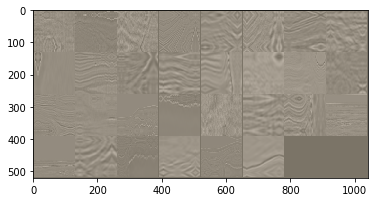

In [11]:
# 可视化
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs = next(iter(data.DataLoader(dataset, batch_size = 30, shuffle = True)))[0]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

## 二、加载模型

### 1. VGG19_U-net

In [170]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)





class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            # 图扩大一倍
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class UNet19(nn.Module):
    def __init__(self, num_filters=32):
        """
        :param num_classes:
        :param num_filters:
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        # Convolutions are from VGG11
        self.encoder = models.vgg19(pretrained=True).features
        
        # "relu" layer is taken from VGG probably for generality, but it's not clear 
        self.relu = self.encoder[1]
        
        self.conv1 = self.encoder[0]
        self.conv12 = self.encoder[2]
        
        self.conv2 = self.encoder[5]
        self.conv22 = self.encoder[7]
        
        self.conv3s = self.encoder[10]
        self.conv3 = self.encoder[12]
        self.conv32 = self.encoder[14]
        self.conv33 = self.encoder[16]
        
        self.conv4s = self.encoder[19]
        self.conv4 = self.encoder[21]
        self.conv42 = self.encoder[23]
        self.conv43 = self.encoder[25]
        
        self.conv5s = self.encoder[28]
        self.conv5 = self.encoder[30]
        self.conv52 = self.encoder[32]
        self.conv53 = self.encoder[34]
        
        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)
        
        self.final = nn.Conv2d(num_filters, 1, kernel_size=1, )

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))                   # (batchsize, 3, 128, 128) -> (batchsize, 64, 128, 128)
        conv11 = self.relu(self.conv12(conv1))              # (batchsize, 64, 128, 128)-> (batchsize, 64, 128, 128)
        
        conv2 = self.relu(self.conv2(self.pool(conv11)))    # (batchsize, 64, 128, 128) -> (batchsize, 128, 64, 64)
        conv22 = self.relu(self.conv22(conv2))              # (batchsize, 64, 128, 128) -> (batchsize, 128, 64, 64)

        
        conv3s = self.relu(self.conv3s(self.pool(conv22)))  # (batchsize, 128, 64, 64) -> (batchsize, 256, 32, 32)
        conv3 = self.relu(self.conv3(conv3s))              # (batchsize, 256, 32, 32) -> (batchsize, 256, 32, 32)
        conv33 = self.relu(self.conv32(conv3))              # (batchsize, 256, 32, 32) -> (batchsize, 256, 32, 32)
        conv333 = self.relu(self.conv33(conv33))              # (batchsize, 256, 32, 32) -> (batchsize, 256, 32, 32)

        
        conv4s = self.relu(self.conv4s(self.pool(conv333)))  # (batchsize, 256, 32, 32) -> (batchsize, 512, 16, 16)
        conv4 = self.relu(self.conv4(conv4s))              # (batchsize, 512, 16, 16)-> (batchsize, 512, 16, 16)
        conv44 = self.relu(self.conv42(conv4))              # (batchsize, 512, 16, 16)-> (batchsize, 512, 16, 16)
        conv444 = self.relu(self.conv43(conv44))              # (batchsize, 512, 16, 16)-> (batchsize, 512, 16, 16)


        
        conv5s = self.relu(self.conv5s(self.pool(conv444)))  # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)
        conv5 = self.relu(self.conv5(conv5s))              # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)
        conv55 = self.relu(self.conv52(conv5))              # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)
        conv555 = self.relu(self.conv53(conv55))              # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)
        
        center = self.center(self.pool(conv555))             # (batchsize, 512, 8, 8)-> (batchsize, 256, 8, 8) 

        # Deconvolutions with copies of VGG11 layers of corresponding size 
        dec5 = self.dec5(torch.cat([center, conv55], 1))   # (batchsize, 768, 8, 8)-> (batchsize, 256, 16, 16)
        dec4 = self.dec4(torch.cat([dec5, conv444], 1))     # (batchsize, 768, 16, 16)-> (batchsize, 128, 32, 32)
        dec3 = self.dec3(torch.cat([dec4, conv333], 1))     # (batchsize, 384, 32, 32)-> (batchsize, 64, 64, 64)
        dec2 = self.dec2(torch.cat([dec3, conv22], 1))     # (batchsize, 192, 64, 64)-> (batchsize, 32, 128, 128)
        dec1 = self.dec1(torch.cat([dec2, conv11], 1))     # (batchsize, 96, 128, 128)-> (batchsize, 32, 128, 128)
        
        return F.sigmoid(self.final(dec1))                # (batchsize, 32, 128, 128)-> (batchsize, 1, 128, 128)


def unet11(**kwargs):
    model = UNet19(**kwargs)

    return model

def get_model19():
    model = unet11()
    model.train()
    return model.to(device)

### 2. VGG16_U-net

In [53]:

def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            # 图扩大一倍
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )
        

    def forward(self, x):
        return self.block(x) 


class UNet16(nn.Module):
    def __init__(self, num_filters=32):
        """
        :param num_classes:
        :param num_filters:
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        # Convolutions are from VGG16
        self.encoder = models.vgg16(pretrained=True).features
        
        # "relu" layer is taken from VGG probably for generality, but it's not clear 
        self.relu = self.encoder[1]
        
        self.conv1 = self.encoder[0]
        self.conv12 = self.encoder[2]
        
        self.conv2 = self.encoder[5]
        self.conv22 = self.encoder[7]
        
        self.conv3s = self.encoder[10]
        self.conv3 = self.encoder[12]
        self.conv32 = self.encoder[14]
        
        self.conv4s = self.encoder[17]
        self.conv4 = self.encoder[19]
        self.conv42 = self.encoder[21]
        
        self.conv5s = self.encoder[24]
        self.conv5 = self.encoder[26]
        self.conv52 = self.encoder[28]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)
        
        self.final = nn.Conv2d(num_filters, 1, kernel_size=1, )

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))                   # (batchsize, 3, 128, 128) -> (batchsize, 64, 128, 128)
        conv11 = self.relu(self.conv12(conv1))              # (batchsize, 64, 128, 128)-> (batchsize, 64, 128, 128)
        
        conv2 = self.relu(self.conv2(self.pool(conv11)))    # (batchsize, 64, 128, 128) -> (batchsize, 128, 64, 64)
        conv22 = self.relu(self.conv22(conv2))              # (batchsize, 64, 128, 128) -> (batchsize, 128, 64, 64)

        
        conv3s = self.relu(self.conv3s(self.pool(conv22)))  # (batchsize, 128, 64, 64) -> (batchsize, 256, 32, 32)
        conv3 = self.relu(self.conv3(conv3s))              # (batchsize, 256, 32, 32) -> (batchsize, 256, 32, 32)
        conv33 = self.relu(self.conv32(conv3))              # (batchsize, 256, 32, 32) -> (batchsize, 256, 32, 32)

        
        conv4s = self.relu(self.conv4s(self.pool(conv33)))  # (batchsize, 256, 32, 32) -> (batchsize, 512, 16, 16)
        conv4 = self.relu(self.conv4(conv4s))              # (batchsize, 512, 16, 16)-> (batchsize, 512, 16, 16)
        conv44 = self.relu(self.conv4(conv4))              # (batchsize, 512, 16, 16)-> (batchsize, 512, 16, 16)

        
        conv5s = self.relu(self.conv5s(self.pool(conv44)))  # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)
        conv5 = self.relu(self.conv5(conv5s))              # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)
        conv55 = self.relu(self.conv5(conv5))              # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)

        
        center = self.center(self.pool(conv55))             # (batchsize, 512, 8, 8)-> (batchsize, 256, 8, 8) 

        # Deconvolutions with copies of VGG11 layers of corresponding size 
        dec5 = self.dec5(torch.cat([center, conv55], 1))   # (batchsize, 768, 8, 8)-> (batchsize, 256, 16, 16)
        dec4 = self.dec4(torch.cat([dec5, conv44], 1))     # (batchsize, 768, 16, 16)-> (batchsize, 128, 32, 32)
        dec3 = self.dec3(torch.cat([dec4, conv33], 1))     # (batchsize, 384, 32, 32)-> (batchsize, 64, 64, 64)
        dec2 = self.dec2(torch.cat([dec3, conv22], 1))     # (batchsize, 192, 64, 64)-> (batchsize, 32, 128, 128)
        dec1 = self.dec1(torch.cat([dec2, conv11], 1))     # (batchsize, 96, 128, 128)-> (batchsize, 32, 128, 128)
        
        return F.sigmoid(self.final(dec1))                # (batchsize, 32, 128, 128)-> (batchsize, 1, 128, 128)


def unet11(**kwargs):
    model = UNet16(**kwargs)

    return model

def get_model16():
    model = unet11()
    model.train()
    return model.to(device)

### 3.VGG11_U-net

In [13]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            # 图扩大一倍
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )
        nn.init.xavier_uniform(self.block.weight)

    def forward(self, x):
        return self.block(x)


class UNet11(nn.Module):
    def __init__(self, num_filters=32):
        """
        :param num_classes:
        :param num_filters:
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        # Convolutions are from VGG11
        self.encoder = models.vgg11(pretrained=True).features
        
        # "relu" layer is taken from VGG probably for generality, but it's not clear 
        self.relu = self.encoder[1]
        
        self.conv1 = self.encoder[0]
        self.conv2 = self.encoder[3]
        self.conv3s = self.encoder[6]
        self.conv3 = self.encoder[8]
        self.conv4s = self.encoder[11]
        self.conv4 = self.encoder[13]
        self.conv5s = self.encoder[16]
        self.conv5 = self.encoder[18]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)
        
        self.final = nn.Conv2d(num_filters, 1, kernel_size=1, )
        self.change = nn.Conv2d(1, 1, kernel_size=1, )

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))                   # (batchsize, 3, 128, 128) -> (batchsize, 64, 128, 128)
        conv2 = self.relu(self.conv2(self.pool(conv1)))    # (batchsize, 64, 128, 128) -> (batchsize, 128, 64, 64)
        conv3s = self.relu(self.conv3s(self.pool(conv2)))  # (batchsize, 128, 64, 64) -> (batchsize, 256, 32, 32)
        conv3 = self.relu(self.conv3(conv3s))              # (batchsize, 256, 32, 32) -> (batchsize, 256, 32, 32)
        conv4s = self.relu(self.conv4s(self.pool(conv3)))  # (batchsize, 256, 32, 32) -> (batchsize, 512, 16, 16)
        conv4 = self.relu(self.conv4(conv4s))              # (batchsize, 512, 16, 16)-> (batchsize, 512, 16, 16)
        conv5s = self.relu(self.conv5s(self.pool(conv4)))  # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)
        conv5 = self.relu(self.conv5(conv5s))              # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)

        center = self.center(self.pool(conv5))             # (batchsize, 512, 8, 8)-> (batchsize, 256, 8, 8) 

        # Deconvolutions with copies of VGG11 layers of corresponding size 
        dec5 = self.dec5(torch.cat([center, conv5], 1))   # (batchsize, 768, 8, 8)-> (batchsize, 256, 16, 16)
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))     # (batchsize, 768, 16, 16)-> (batchsize, 128, 32, 32)
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))     # (batchsize, 384, 32, 32)-> (batchsize, 64, 64, 64)
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))     # (batchsize, 192, 64, 64)-> (batchsize, 32, 128, 128)
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))     # (batchsize, 96, 128, 128)-> (batchsize, 32, 128, 128)
        dec0 = self.final(dec1)
        
        
        return F.sigmoid(self.change(dec0))                # (batchsize, 32, 128, 128)-> (batchsize, 1, 128, 128)


def unet11(**kwargs):
    model = UNet11(**kwargs)

    return model

def get_model():
    model = unet11()
    model.train()
    return model.to(device)

In [14]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class UNet11(nn.Module):
    def __init__(self, num_filters=32):
        """
        :param num_classes:
        :param num_filters:
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        # Convolutions are from VGG11
        self.encoder = models.vgg11(pretrained=True).features
        
        # "relu" layer is taken from VGG probably for generality, but it's not clear 
        self.relu = self.encoder[1]
        
        self.conv1 = self.encoder[0]
        self.conv2 = self.encoder[3]
        self.conv3s = self.encoder[6]
        self.conv3 = self.encoder[8]
        self.conv4s = self.encoder[11]
        self.conv4 = self.encoder[13]
        self.conv5s = self.encoder[16]
        self.conv5 = self.encoder[18]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)
        
        self.final = nn.Conv2d(num_filters, 1, kernel_size=1, )

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))                   # (batchsize, 3, 128, 128) -> (batchsize, 64, 128, 128)
        conv2 = self.relu(self.conv2(self.pool(conv1)))    # (batchsize, 64, 128, 128) -> (batchsize, 128, 64, 64)
        conv3s = self.relu(self.conv3s(self.pool(conv2)))  # (batchsize, 128, 64, 64) -> (batchsize, 256, 32, 32)
        conv3 = self.relu(self.conv3(conv3s))              # (batchsize, 256, 32, 32) -> (batchsize, 256, 32, 32)
        conv4s = self.relu(self.conv4s(self.pool(conv3)))  # (batchsize, 256, 32, 32) -> (batchsize, 512, 16, 16)
        conv4 = self.relu(self.conv4(conv4s))              # (batchsize, 512, 16, 16)-> (batchsize, 512, 16, 16)
        conv5s = self.relu(self.conv5s(self.pool(conv4)))  # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)
        conv5 = self.relu(self.conv5(conv5s))              # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)

        center = self.center(self.pool(conv5))             # (batchsize, 512, 8, 8)-> (batchsize, 256, 8, 8) 

        # Deconvolutions with copies of VGG11 layers of corresponding size 
        dec5 = self.dec5(torch.cat([center, conv5], 1))   # (batchsize, 768, 8, 8)-> (batchsize, 256, 16, 16)
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))     # (batchsize, 768, 16, 16)-> (batchsize, 128, 32, 32)
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))     # (batchsize, 384, 32, 32)-> (batchsize, 64, 64, 64)
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))     # (batchsize, 192, 64, 64)-> (batchsize, 32, 128, 128)
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))     # (batchsize, 96, 128, 128)-> (batchsize, 32, 128, 128)        
        
        return F.sigmoid(self.final(dec1))                # (batchsize, 32, 128, 128)-> (batchsize, 1, 128, 128)

def unet11(**kwargs):
    model = UNet11(**kwargs)

    return model

def get_model():
    model = unet11()
    model.train()
    return model.to(device)

### 4. 个人使用

In [13]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x



def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        nn.init.xavier_uniform(self.conv.weight)
        self.activation = nn.PReLU()(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            # 图扩大一倍
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.PReLU()(inplace=True)
        )
        nn.init.xavier_uniform(self.block[1].weight)
        
    def forward(self, x):
        return self.block(x) 


class UNet16(nn.Module):
    def __init__(self, num_filters=32):
        """
        :param num_classes:
        :param num_filters:
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        # Convolutions are from VGG16
        self.encoder = models.vgg16(pretrained=True).features
        
        # "relu" layer is taken from VGG probably for generality, but it's not clear 
        self.relu = nn.PReLU()(inplace=True)
        
        self.conv1 = self.encoder[0]
        self.conv12 = self.encoder[2]
        
        self.conv2 = self.encoder[5]
        self.conv22 = self.encoder[7]
        
        self.conv3s = self.encoder[10]
        self.conv3 = self.encoder[12]
        self.conv32 = self.encoder[14]
        
        self.conv4s = self.encoder[17]
        self.conv4 = self.encoder[19]
        self.conv42 = self.encoder[21]
        
        self.conv5s = self.encoder[24]
        self.conv5 = self.encoder[26]
        self.conv52 = self.encoder[28]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)
        
        self.final = nn.Conv2d(num_filters, 1, kernel_size=1, )

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))                   # (batchsize, 3, 128, 128) -> (batchsize, 64, 128, 128)
        conv11 = self.relu(self.conv12(conv1))              # (batchsize, 64, 128, 128)-> (batchsize, 64, 128, 128)
        
        conv2 = self.relu(self.conv2(self.pool(conv11)))    # (batchsize, 64, 128, 128) -> (batchsize, 128, 64, 64)
        conv22 = self.relu(self.conv22(conv2))              # (batchsize, 64, 128, 128) -> (batchsize, 128, 64, 64)

        
        conv3s = self.relu(self.conv3s(self.pool(conv22)))  # (batchsize, 128, 64, 64) -> (batchsize, 256, 32, 32)
        conv3 = self.relu(self.conv3(conv3s))              # (batchsize, 256, 32, 32) -> (batchsize, 256, 32, 32)
        conv33 = self.relu(self.conv32(conv3))              # (batchsize, 256, 32, 32) -> (batchsize, 256, 32, 32)

        
        conv4s = self.relu(self.conv4s(self.pool(conv33)))  # (batchsize, 256, 32, 32) -> (batchsize, 512, 16, 16)
        conv4 = self.relu(self.conv4(conv4s))              # (batchsize, 512, 16, 16)-> (batchsize, 512, 16, 16)
        conv44 = self.relu(self.conv42(conv4))              # (batchsize, 512, 16, 16)-> (batchsize, 512, 16, 16)

        
        conv5s = self.relu(self.conv5s(self.pool(conv44)))  # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)
        conv5 = self.relu(self.conv5(conv5s))              # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)
        conv55 = self.relu(self.conv52(conv5))              # (batchsize, 512, 8, 8)-> (batchsize, 512, 8, 8)

        
        center = self.center(self.pool(conv55))             # (batchsize, 512, 8, 8)-> (batchsize, 256, 8, 8) 

        # Deconvolutions with copies of VGG11 layers of corresponding size 
        dec5 = self.dec5(torch.cat([center, conv55], 1))   # (batchsize, 768, 8, 8)-> (batchsize, 256, 16, 16)
        dec4 = self.dec4(torch.cat([dec5, conv44], 1))     # (batchsize, 768, 16, 16)-> (batchsize, 128, 32, 32)
        dec3 = self.dec3(torch.cat([dec4, conv33], 1))     # (batchsize, 384, 32, 32)-> (batchsize, 64, 64, 64)
        dec2 = self.dec2(torch.cat([dec3, conv22], 1))     # (batchsize, 192, 64, 64)-> (batchsize, 32, 128, 128)
        dec1 = self.dec1(torch.cat([dec2, conv11], 1))     # (batchsize, 96, 128, 128)-> (batchsize, 32, 128, 128)
        
        return F.sigmoid(self.final(dec1))                # (batchsize, 32, 128, 128)-> (batchsize, 1, 128, 128)


def unet11(**kwargs):
    model = UNet16(**kwargs)

    return model

def get_model16():
    model = unet11()
    model.train()
    return model.to(device)

In [171]:
del model
import gc
gc.collect()

438

In [172]:
model = get_model19()

In [180]:
model = torch.load('C:/1.PlayGround/trained_models/3_0.106.pkl')    

## 三、设置必要的参数 

In [176]:
# 设置为GPU处理
learning_rate = 1e-5
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [174]:
epoch = 5

In [179]:
for e in range(epoch):
    train_loss = []
    for image, mask in tqdm(data.DataLoader(dataset, batch_size = 30, shuffle = True)):
        image = image.type(torch.FloatTensor).cuda()
        y_pred = model(Variable(image))
        loss = loss_fn(y_pred, Variable(mask.cuda()))

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss.append(loss.item())
        
    val_loss = []
    for image, mask in data.DataLoader(dataset_val, batch_size = 16, shuffle = False):
        image = image.cuda()
        y_pred = model(Variable(image))

        loss = loss_fn(y_pred, Variable(mask.cuda()))
        val_loss.append(loss.item())
        
        
    TrainedModel_path = './trained_models/%d' % (e + 1) + '_' + '%.3f' % np.mean(val_loss) + '.pkl'
    torch.save(model, TrainedModel_path)

    print("Epoch: %d, Train: %.3f, Val: %.3f" % (e, np.mean(train_loss), np.mean(val_loss)))
# save the final model
# save_checkpoint('unet19tgs-%i.pth' % 3, model, optimizer)

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 0, Train: 0.085, Val: 0.116


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 1, Train: 0.080, Val: 0.107


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 2, Train: 0.078, Val: 0.106


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 3, Train: 0.072, Val: 0.109


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 4, Train: 0.068, Val: 0.110


In [154]:
class TGSSaltDataset_aug(data.Dataset):
    def __init__(self, root_path, file_list, is_test = False):
        self.is_test = is_test
        self.root_path = root_path
        self.file_list = file_list
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        
        file_id = self.file_list[index]
        
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        
        image = load_image(image_path)
        
        if self.is_test:
            return (image,)
        else:
            mask = load_image(mask_path, mask = True)
            image = np.append(image, [np.fliplr(x) for x in image], axis=0)[3:6]
            
            mask = np.append(mask, [np.fliplr(x) for x in mask], axis=0)[1:2]
            return image, mask

In [136]:
dataset1 = TGSSaltDataset_aug(train_path, file_list_train)


In [181]:
import glob

test_path = os.path.join(directory, 'test/')
test_file_list = glob.glob(os.path.join(test_path, 'images/', '*.png'))
test_file_list = [f.split('/')[-1].split('.')[0] for f in test_file_list]
test_file_list = [f.split('\\')[1] for f in test_file_list]
test_file_list[:3], test_path

(['0005bb9630', '000a68e46c', '000c8dfb2a'], 'C:/1.PlayGround/Salt/data/test/')

In [182]:
print(len(test_file_list))
test_dataset = TGSSaltDataset(test_path, test_file_list, is_test = True)
all_predictions = []

for image in tqdm(data.DataLoader(test_dataset, batch_size = 30)):
    image = image[0].type(torch.float).to(device)
    y_pred = model(image).cpu().detach().numpy()
    all_predictions.append(y_pred)

# 把通道数去掉了
all_predictions_stacked = np.vstack(all_predictions)[:, 0, :, :]

18000


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:57<00:00,  5.15it/s]


In [183]:
# 为了得到填充的值
height, width = 101, 101

if height % 32 == 0:
    y_min_pad = 0
    y_max_pad = 0
else:
    y_pad = 32 - height % 32
    y_min_pad = int(y_pad / 2)
    y_max_pad = y_pad - y_min_pad

if width % 32 == 0:
    x_min_pad = 0
    x_max_pad = 0
else:
    x_pad = 32 - width % 32
    x_min_pad = int(x_pad / 2)
    x_max_pad = x_pad - x_min_pad

In [184]:
# 去掉生成的填充的部分
all_predictions_stacked = all_predictions_stacked[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]

In [185]:
all_predictions_stacked.shape

(18000, 101, 101)

In [186]:
test_dataset = TGSSaltDataset(test_path, test_file_list, is_test = True)

# 这里主要是得到网络在验证集上的输出，方便后面得到阈值
val_predictions = []
val_masks = []
for image, mask in tqdm(data.DataLoader(dataset_val, batch_size = 30)):
    image = image.type(torch.float).to(device)
    y_pred = model(image).cpu().detach().numpy()
    val_predictions.append(y_pred)
    val_masks.append(mask)
    
val_predictions_stacked = np.vstack(val_predictions)[:, 0, :, :]

val_masks_stacked = np.vstack(val_masks)[:, 0, :, :]
val_predictions_stacked = val_predictions_stacked[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]

val_masks_stacked = val_masks_stacked[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]
val_masks_stacked.shape, val_predictions_stacked.shape

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.02it/s]


((400, 101, 101), (400, 101, 101))

In [187]:
val_predictions_stacked[0]

array([[1.5099642e-05, 1.1287054e-05, 9.8268511e-06, ..., 3.5493558e-03,
        5.5819820e-03, 7.2957980e-03],
       [1.8748511e-05, 1.2406337e-05, 1.3738558e-05, ..., 3.7192025e-03,
        5.8431397e-03, 7.6703373e-03],
       [1.6305707e-05, 1.4831691e-05, 1.1952529e-05, ..., 3.1428088e-03,
        5.2631213e-03, 6.8868580e-03],
       ...,
       [1.8919878e-04, 1.7524157e-04, 1.4785765e-04, ..., 3.1536390e-05,
        3.9305160e-05, 4.7513160e-05],
       [2.1093331e-04, 1.6349228e-04, 1.6095814e-04, ..., 2.9626344e-05,
        3.2309330e-05, 4.7382888e-05],
       [2.3068105e-04, 1.8080625e-04, 1.6444884e-04, ..., 2.8191511e-05,
        3.7881342e-05, 4.6875168e-05]], dtype=float32)

In [188]:
from sklearn.metrics import jaccard_similarity_score

metric_by_threshold = []
for threshold in np.linspace(0, 1, 100):
    val_binary_prediction = (val_predictions_stacked > threshold).astype(int)
    
    iou_values = []
    for y_mask, p_mask in zip(val_masks_stacked, val_binary_prediction):
        iou = jaccard_similarity_score(y_mask.flatten(), p_mask.flatten())
        iou_values.append(iou)
    iou_values = np.array(iou_values)
    
    accuracies = [np.mean(iou_values > iou_threshold) for iou_threshold in np.linspace(0.5, 0.95, 10)]
    
    print('Threshold: %.1f, Metric: %.3f' % (threshold, np.mean(accuracies)))
    metric_by_threshold.append((np.mean(accuracies), threshold))
    
best_metric, best_threshold = max(metric_by_threshold)

Threshold: 0.0, Metric: 0.138
Threshold: 0.0, Metric: 0.747
Threshold: 0.0, Metric: 0.798
Threshold: 0.0, Metric: 0.833
Threshold: 0.0, Metric: 0.857
Threshold: 0.1, Metric: 0.874
Threshold: 0.1, Metric: 0.887
Threshold: 0.1, Metric: 0.899
Threshold: 0.1, Metric: 0.905
Threshold: 0.1, Metric: 0.907
Threshold: 0.1, Metric: 0.912
Threshold: 0.1, Metric: 0.915
Threshold: 0.1, Metric: 0.918
Threshold: 0.1, Metric: 0.922
Threshold: 0.1, Metric: 0.924
Threshold: 0.2, Metric: 0.927
Threshold: 0.2, Metric: 0.929
Threshold: 0.2, Metric: 0.930
Threshold: 0.2, Metric: 0.933
Threshold: 0.2, Metric: 0.933
Threshold: 0.2, Metric: 0.936
Threshold: 0.2, Metric: 0.937
Threshold: 0.2, Metric: 0.939
Threshold: 0.2, Metric: 0.939
Threshold: 0.2, Metric: 0.940
Threshold: 0.3, Metric: 0.941
Threshold: 0.3, Metric: 0.941
Threshold: 0.3, Metric: 0.942
Threshold: 0.3, Metric: 0.943
Threshold: 0.3, Metric: 0.943
Threshold: 0.3, Metric: 0.944
Threshold: 0.3, Metric: 0.944
Threshold: 0.3, Metric: 0.944
Threshold:

In [189]:
best_threshold

0.7272727272727273

In [190]:
threshold = best_threshold
binary_prediction = (all_predictions_stacked > threshold).astype(int)

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

all_masks = []
for p_mask in list(binary_prediction):
    p_mask = rle_encoding(p_mask)
    all_masks.append(' '.join(map(str, p_mask)))

In [166]:
submit = pd.DataFrame([test_file_list, all_masks]).T
submit.columns = ['id', 'rle_mask']
submit.to_csv('submit_baseline816ssssSS.csv.gz', compression = 'gzip', index = False)